# Описание проекта

Контекст

Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

#### Оглавление

### [Часть 1. Приоритизация гипотез.](#Часть_1)
 * [Выгружаем данные](#Шаг_1)
 * [Применяем фреймворк ICE для приоритизации гипотез](#Шаг_2)
 * [Применяем фреймворк RICE для приоритизации гипотез](#Шаг_3)
 * [Выводы](#Шаг_4)

### [Часть 2. Анализ A/B-теста](#Часть_2)
 * [Выгружаем данные](#Шаг_1_2)
 * [Кумулятивные выручка, средний чек и конверсия](#Шаг_2_2)
 * [Кумулятивная конверсия](#Шаг_3_2)
 * [Заказы](#Шаг_4_2)
 * [Считаем статистическую значимость](#Шаг_5_3)

### [Общий вывод](#Вывод)

<a id = 'Часть_1' > </a> 
# Часть 1. Приоритизация гипотез

<a id = 'Шаг_1' > </a> 
### Выгружаем данные

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
hypothesis.head(2)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10


In [4]:
hypothesis.columns = ['hypothesis','reach','impact','confidence','efforts']

In [5]:
hypothesis.head(4)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8


* Hypothesis — краткое описание гипотезы;
*  Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

<a id = 'Шаг_2' > </a> 
### Применяем фреймворк ICE для приоритизации гипотез

In [6]:
hypothesis['sorting_ice'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).astype(int)

In [7]:
hypothesis_ice = hypothesis.sort_values(by = 'sorting_ice', ascending = False).reset_index()
hypothesis_ice.head(3).drop(labels = 'index', axis = 1)

,hypothesis,reach,impact,confidence,efforts,sorting_ice
0,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16
1,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13
2,Добавить форму подписки на все основные страни...,10,7,8,5,11


In [8]:
hypothesis_ice['hypothesis'][0]

'Запустить акцию, дающую скидку на товар в день рождения'

<a id = 'Шаг_3' > </a> 
### Применяем фреймворк RICE для приоритизации гипотез

In [9]:
hypothesis['sorting_rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).astype('int')
hypothesis_rice = hypothesis.sort_values(by = 'sorting_rice', ascending = False).reset_index()

In [10]:
pd.options.display.max_colwidth = 150
hypothesis_rice.head(3).drop(labels = 'index', axis = 1)

,hypothesis,reach,impact,confidence,efforts,sorting_ice,sorting_rice
0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11,112
1,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13,40


<a id = 'Шаг_4' > </a> 
## Выводы

Видим, что при применени фреймворка ICE приоритетной гипотезой оказалась гипотеза о скидке в день рождения. При приоритизации RICЕ, на первом месте находится гипотеза о подписке на email-рассылки. 
Различия в приоритетах обусловлены тем, что во фреймворке ICE не учитывается параметр количества пользователей, которых затронет изменение. Поэтому, например, в первом случае приоритетной оказалась гипотеза о днях рождениях, однако из таблицы видим, что reach у этой гипотезы = 1, скорее всего, это объясняется тем, что только небольшое количество людей готово предоставить свои личные данные.
При этом во втором случае(RICE), параметр количества пользователей вносит значительный вклад в итоговое число, поскольку данное изменение скорее всего охватит всех пользователей.

<a id = 'Часть_2' > </a> 
# Часть 2. Анализ A/B-теста

<a id = 'Шаг_1_2' > </a> 
### Шаг 1. Выгружаем данные

##### Описание данных 

Файл /datasets/orders.csv. 
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

In [11]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [12]:
display(orders.info())
display(orders.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

0

In [13]:
orders['date'] = orders['date'].map(lambda x : dt.datetime.strptime(x, '%Y-%m-%d'))

In [14]:
orders.columns = ['transaction_id','visitor_id','date','revenue','group']
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Файл /datasets/visitors.csv.
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [15]:
visitors['date'] = visitors['date'].map(lambda x : dt.datetime.strptime(x, '%Y-%m-%d'))

In [16]:
display(visitors.info())
display(visitors.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

0

Посмотрим, есть ли пересечения пользователей по группам.

In [17]:
orders_visitors = orders.groupby('visitor_id').agg({'group':'nunique'})
orders_visitors.columns = ['number_groups']
orders_visitors[orders_visitors['number_groups'] > 1].count()

number_groups    58
dtype: int64

In [18]:
orders.groupby('group').agg({'visitor_id':'nunique'})

,visitor_id
group,
A,503
B,586


Видим, что небольшое количество пользователей пересекается по группам(примерно 5%). Вероятно это происходит из-за того, что люди заходят с разных устройств.

Пропуски и дубликаты отсутствуют, данные приведены к правильным типам и готовы к дальнейшему анализу.

<a id = 'Шаг_2_2' > </a> 
### Шаг 2. Проанализируем А/В тест.

##### Построим график кумулятивной выручки по группам.

In [19]:
# массив уникальных пар значений дат и групп
datesGroups = orders[['date','group']].drop_duplicates() 
datesGroups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [20]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [21]:
# получим агрегированные кумулятивные по дням данные о заказах
aggorders = datesGroups.apply(lambda x : orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                             .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
aggorders

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


In [22]:
# Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина
aggvisitors = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
{'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1).sort_values(by = ['date','group'])

In [23]:
# объединяем кумулятивные данные в одной таблице 
cumulativeData = aggorders.merge(aggvisitors, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']


Построим графики кумулятивной выручки.

In [24]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]

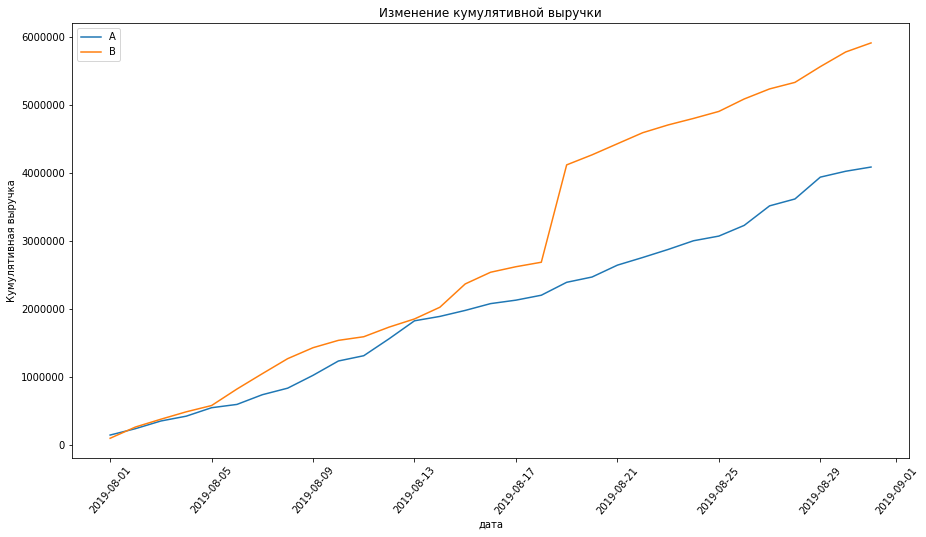

In [25]:
plt.figure(figsize = (15,8))
plt.xlabel('дата')
plt.ylabel('Кумулятивная выручка')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend() 
plt.xticks(rotation=50)
plt.title('Изменение кумулятивной выручки')
plt.show()

Выручка равномерно увеличивается в течение всего теста. Видим так же, что в группе B в одной точке график резко растет. Это может свидетельствовать о какой-либо аномалии, либо очень дорогой покупке

##### Построим график кумулятивного среднего чека

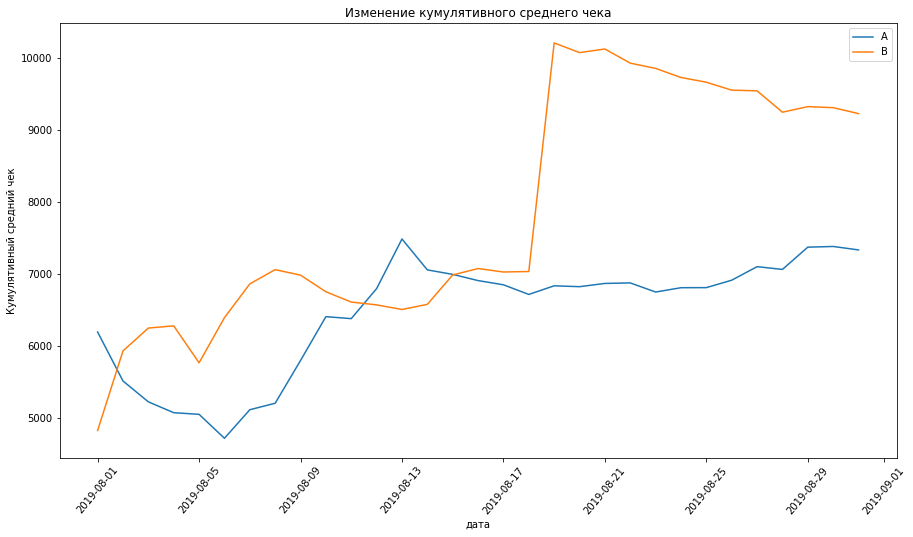

In [26]:
# Разделим кумулятивную выручку на число заказов
plt.figure(figsize = (15,8))
plt.xlabel('дата')
plt.ylabel('Кумулятивный средний чек')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.xticks(rotation=50)
plt.title('Изменение кумулятивного среднего чека')
plt.show()

Средний чек активно рос и ближе к концу наблюдений становится равномерным. У B падает после резкого роста, у А установился на одном уровне. Резкие всплески скорее всего говорят о том, что имели место дорогие заказы между 17 и 21 числами.

##### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

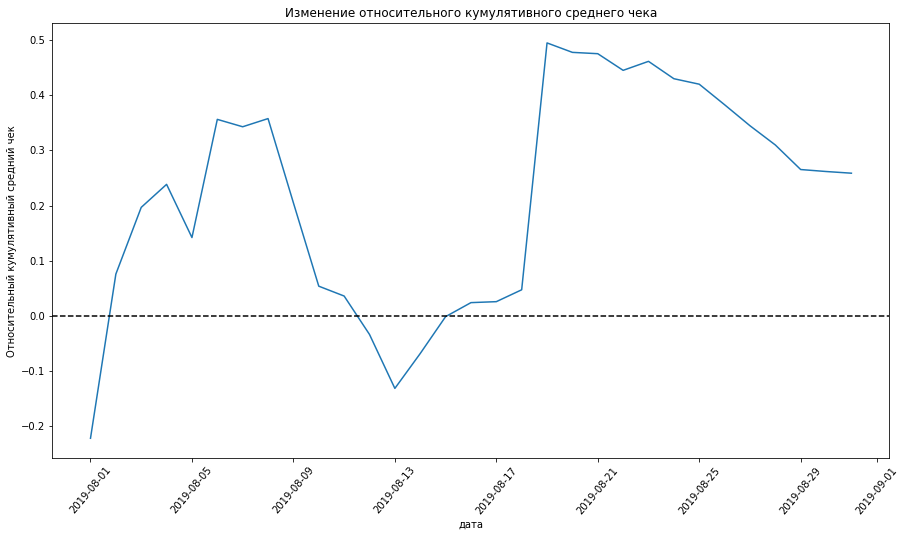

In [27]:
plt.figure(figsize = (15,8))
plt.xlabel('дата')
plt.ylabel('Относительный кумулятивный средний чек')
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']
                                          )/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=50)
plt.title('Изменение относительного кумулятивного среднего чека')
plt.show()

Из графика видим, что большую часть времени график различия между группами скачет, выравниваясь только к концу. Вероятнее всего это выбросы и дорогие заказы.

<a id='Шаг_3_2' > </a>
###### Построим график кумулятивной конверсии по группам.

In [28]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

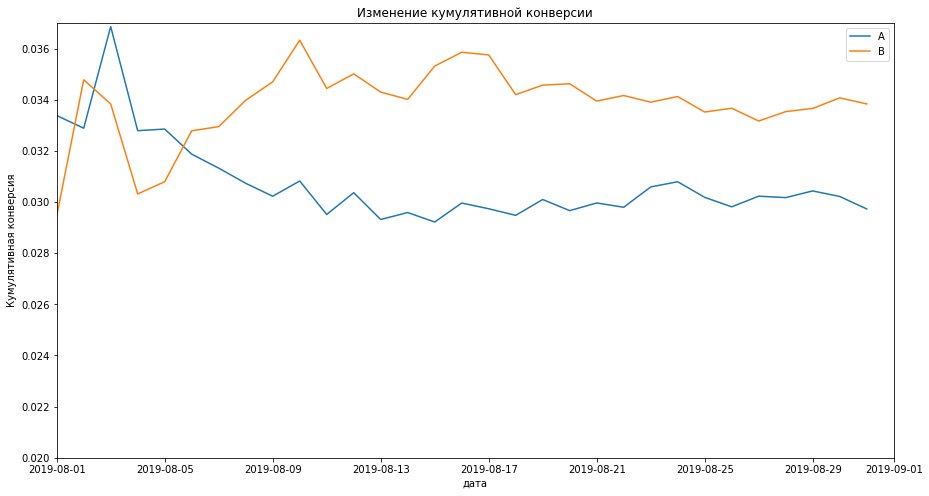

In [29]:
plt.figure(figsize = (15,8))
plt.xlabel('дата')
plt.ylabel('Кумулятивная конверсия')
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('Изменение кумулятивной конверсии')
plt.axis(["2019-08-01", '2019-09-01', 0.02, 0.037])
plt.show()

Из графика видим, что конверсия еще не установилась. Однако к концу наблюдений наметился тренд на выравнивание. Конверсия группы А поначалу была выше, но затем сильно просела и несильно колебалась возле значеия 0.03.

##### Построим график относительного изменения кумулятивной конверсии группы B к группе A.

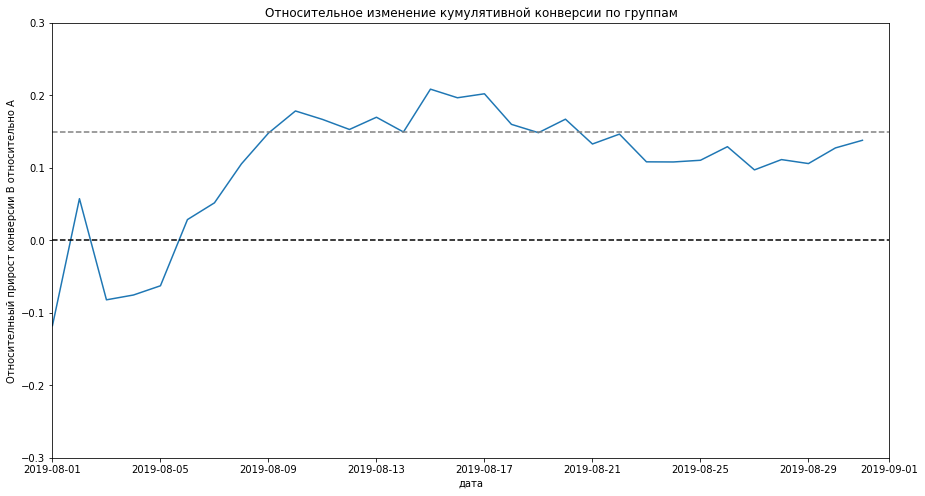

In [30]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize = (15,8))
plt.xlabel('дата')
plt.ylabel('Относителньый прирост конверсии В относительно А')
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.title('Относительное изменение кумулятивной конверсии по группам')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.3, 0.3])
plt.show()

Из графика видно, что в начале теста группа В проигрывала А, затем был резкий скачок и такое же падение. После конверсия группы В по отношению к А начала стремительно расти и конверсия В стала выигрывать у А. К концу наблюдений конверсия группы В зафиксировалась около прироста 15% относительно конверсии А.

На данном этапе нельзя точно сделать выводы по тесту, поскольку в данных имеются аномалии и выбросы.

<a id = '#Шаг_4_2' > </a> 
##### Построим точечный график количества заказов по пользователям.

In [31]:
orders_by_visitors = orders.groupby(['visitor_id', 'group'], as_index = False).agg({'transaction_id':'count'})
orders_by_visitors.columns = ['visitor_id', 'group', 'orders_count']
orders_by_visitors

,visitor_id,group,orders_count
0,5114589,B,1
1,6958315,B,1
2,8300375,A,1
3,8300375,B,1
4,11685486,A,1
...,...,...,...
1084,4266935830,B,1
1085,4278982564,A,1
1086,4279090005,B,1
1087,4281247801,B,1


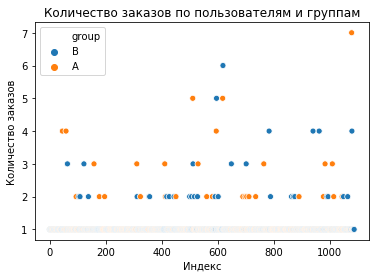

In [32]:
sns.scatterplot(data = orders_by_visitors, x = orders_by_visitors.index, y = orders_by_visitors['orders_count'], hue = 'group')
plt.title("Количество заказов по пользователям и группам")
plt.ylabel('Количество заказов')
plt.xlabel("Индекс")
plt.show()

В основном пользователи совершали по одной покупке. Однако из графика видим, что есть некоторое количество людей, совершивших 3 и более количеество покупок. Например покупатель из группы А совершил 7 покупок, возможно благодаря таким выбросам мы увидели пики ранее на графиках.

Посчитаем перцентели количества заказов.

In [33]:
print(np.percentile(orders_by_visitors['orders_count'], [95,99]))

[2. 4.]


Видим, что не более 5 процентов покупателей, совершивших 2 покупки и больше и не более 1 процента, совершивших 4 и больше.
Логично выбрать за нижнюю границу число заказов равное 2.

<a id ='Шаг_4_2' > </a>
##### Построим точечный график стоимости заказов

In [34]:
x_values = pd.Series(range(0,len(orders['revenue'])))

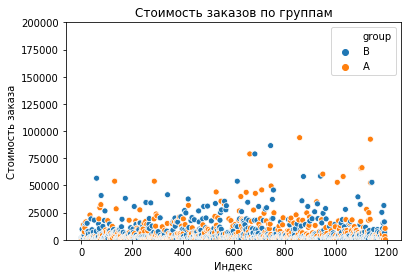

In [35]:
sns.scatterplot(data = orders, x = x_values, y = orders['revenue'], hue = 'group')
plt.title("Стоимость заказов по группам")
plt.ylabel('Стоимость заказа')
plt.xlabel("Индекс")
plt.ylim(0,200000)
plt.show()

Из графика видно, что чаще всего заказы не превышают 30 тысяч. Так же присутствует небольшое количество дорогих заказов(более 50 тысяч).

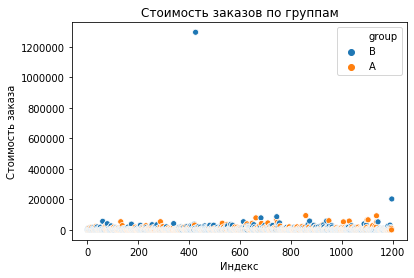

In [36]:
sns.scatterplot(data = orders, x = x_values, y = orders['revenue'], hue = 'group')
plt.title("Стоимость заказов по группам")
plt.ylabel('Стоимость заказа')
plt.xlabel("Индекс")
plt.show()

Видим, что один заказ из группы В имеет аномальное значение стоимости(1200000), вероятнее всего этот заказ влияет на всплески на графике среднего чека.

Посчитаем перцентели стоимости заказов.

In [37]:
print(np.percentile(orders['revenue'], [95,99]))

[28000.  58233.2]


Видим, что не более 5 процентов заказов ценой больше 28000 и не более 1 процента ценой больше 58000. В этом случае так же логично за нижнюю границу взять 95 перцентиль.

### Вывод

На этом шаге были построены различные графики по основным показателям на "сырых" данных, разделенные по группам теста. 
Из графиков куммулятивных показателей, можно сделать вывод о том, что группа В проявляет себя лучше. При этом если по среднему чеку нельзя уверенно сказать о том, какая из групп выигрывает из-за выбросов, сильно повлиявших на общую картину, то по конверсии и выручке В выигрывает у А. На графике кумулятивной выручки группы В можно так же увидеть достаточно резкий всплеск, однако этому предшествовал достаточно стабильный тренд, показывающий результаты лучше чем у группы А.

Так же выбрали нижние границы стоимости и количества заказов для "чистки" данных от аномальных значений и выбросов.

<a id = 'Шаг_4_2' > </a>
### Шаг 3. Считаем статистическую значимость.

##### Считаем статистическую значимость различий в конверсии между группами по «сырым» данным.

In [38]:
# Считаем число визитов по группам и дням.
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


In [39]:
# Считаем число заказов по группам и дням
ordersADaily = orders[orders['group']=='A'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [40]:
ordersBDaily = orders[orders['group']=='B'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [41]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

data

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280
5,2019-08-06,18,48484,28,242342,127,598401,129,824337,667,655,3985,3935
6,2019-08-07,18,142417,24,225334,145,740818,153,1049671,644,709,4629,4644
7,2019-08-08,16,96279,27,220918,161,837097,180,1270589,610,654,5239,5298
8,2019-08-09,16,188506,25,160812,177,1025603,205,1431401,617,610,5856,5908
9,2019-08-10,16,210495,23,107802,193,1236098,228,1539203,406,369,6262,6277


In [42]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['visitor_id', 'orders'] 

In [43]:
# число пользователей, которые заказывали хотя бы 1 раз
ordersByUsersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['visitor_id', 'orders'] 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [44]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

0-гипотеза - статистически значимых различий в конверсии между группами нет.

Aльтернативная гипотеза - между группами имеются статистически значимые различия в конверсиях.

Проверим критерием Манна-Уитни


In [45]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.008
0.138


Первое число - p-value < 0.05, следовательно нулевая гипотеза может быть отвергнута. Таким образом различия в конверсии статистически значимы и относительный выигрышь группы B = 13.8 %.
Можно сказать, что вероятнее всего по сырым данным различие по конверсиям есть.

##### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Нулевая гипотеза -  статистически значимых различий в среднем чеке между группами нет.

Альтернативная гипотеза - между группами имеются статистически значимые различия в среднем чеке с преимуществом более 20 процентов группы В

In [46]:
# Передадим критерию mannwhitneyu() данные о выручке с заказов.
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.365
0.259


P-value значительно > 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом средний чек группы B значительно выше среднего чека А.

##### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

Узнаем число аномальных пользователей.

Нулевая гипотеза: статистически значимых различий между конверсиями в "в очищенных" группах нет

Альтернативная гипотеза: различия в конверсиях статистически значимы

In [47]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'], ordersByUsersB[ordersByUsersB['orders'] > 4]['visitor_id']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.shape)

(68,)


Имеется 68 аномальных пользователей.

In [48]:
# Считаем стат значимость для конверсии на очищенных данных.
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 
# Применим критерий Манна-Уитни
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.006
0.204


Результаты изменились несильно, на очищенных данных различия в конверсии так же статистически значимы (В выигрывает)

##### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [49]:
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

0.394
-0.017


p-value увеличился, а разница между группами на очищенных данных практически отсутствует( 1.7% В проигрывает).

## Выводы

* Различия в конверсии статистически значимы и по сырым и по "фильтрованным" данным, при этом группа В показывает лучшие результаты по сравнению с А
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий, при этом по очищенным данным группа В незначительно проигрывает А, скорее всего пик на графике "сырых" данных исказил общую картину
* График различия конверсии между группами сообщает, что результаты группы B лучше группы A и имеют достаточно стабильный рост
* График различия среднего чека говорит о том, что результаты группы B лучше А, однако это во многом благодаря выбросам. 

Исходя из изложенных фактов, тест следует продолжить для того, чтобы нивелировать влияние выбросов на средний чек группы В. По конверсии добились улучшения показателей.

<a id = 'Шаг_5_3' > </a>
# Общий вывод

В данном проекте на первом шаге была выполнена приоретизация гипотез с помощью фреймворков RICE и ICE. Приоритеты гипотез отличались благодаря учитываемому во фреймворке RICE параметру REACH, поэтому, например, в этом случае приоритетной гипотезой оказалась добавление формы подписки на каждую страницу, поскольку данное изменение затронет всех без исключения пользователей.
А по фреймворку ICE приоритетной оказалсь гипотеза о добавлении скидок ко дню рождения, поскольку она имеет небольшой охват, но скорее всего достаточно эффективна.

Далее был проведен анализ А/В теста. Были построены графики различных кумулятивных метрик и проведены статистические тесты Мана-Уитни по "сырым" данным. После удаления выбросов тесты были проведены снова.
По полученным результатам был сделан вывод о необходимости продолжения теста, поскольку гипотеза о том, что статистически значимых различий в конверсии между группами нет может быть отвергнута и конверсия В выигрывает у А,
а гипотеза о том, что статистически значимых различий в среднем чеке между группами нет не может быть отвергнута.